# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the task of POS tagging.

<center>
    <img src="./images/pos_tagging.png" alt="POS tagging" />
</center>

In [84]:
# best models is a dictionary to store the best models for each seed
# best losses keep track of the best loss for each seed after a training loop, so that we can re-train the model without
#   loosing the best model after the first iteration
# total epochs is a dictionary to keep track of the total epochs for each seed, just for information purposes
# run this cell only once
rerun = False

if rerun:
    best_models = {}
    best_losses = {}
    total_epochs = {}

In [85]:
import os
import pandas as pd
import numpy as np
import random
import warnings
from collections import OrderedDict
import pickle
import re
import torch
from torchtext.vocab import GloVe
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn
import time
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from operator import itemgetter
import spacy

SEED = 2
DATA_FOLDER = './data'
WEIGHTS_FOLDER = './weights'

LOWER = True

NUMBER = False
NUM_RE = r"(\d*\,)?\d+.\d*"
NUM_TOKEN = '<num>'

NER = False
NER_TOKEN = {
    'CARDINAL' : '<num>',
    'ORG' : '<org>',
    'PERSON' : '<per>',
}


PAD_INDEX = 0
PAD_TOKEN = '<pad>'

EMBEDDING_DIMENSION = 300
OOV_EMBEDDING_TYPE = 'random' # either "mean" or "random"
MEAN_EMBEDDING_WINDOW = 1
FIXED_OOV = False
FIXED_OOV_VECTOR = np.random.uniform(low=-0.05, high=0.05, size=EMBEDDING_DIMENSION)

BATCH_SIZE = 16

random.seed(SEED)
np.random.seed(SEED)
warnings.filterwarnings('ignore')
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
nlp = spacy.load('en_core_web_sm')

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

In [86]:
def mask_number(text):
    try:
        if re.match(NUM_RE, text):
            return NUM_TOKEN
        else:
            return text
    except:
        return text

def mask_ner(text_tokens):
    text_tokens_str = [str(token) for token in text_tokens]
    text = ' '.join(text_tokens_str)
    doc = nlp(text)
    for ent in doc.ents:
      if ent.label_ in NER_TOKEN:
          for sub_token in ent.text.split():
            text_tokens[text_tokens == sub_token] = NER_TOKEN[ent.label_]
    return text_tokens

In [87]:
def preprcess_dataset(df) -> pd.DataFrame:
  """
    Preprocess the dataset, lowercase the words and/or mask the numbers
  """
  if NER:
    df['word'] = mask_ner(df['word'])
  if LOWER:
    df['word'] = df["word"].str.lower()
  if NUMBER:
    df['word'] = df['word'].apply(mask_number)
  return df

def encode_dataset(dataset_name: str) -> pd.DataFrame:
  """
    Encode the dataset as a pandas dataframe, each row is a sentence, each sentence is a list of words and a list of corresponding tags
  """
  dataset_folder = os.path.join(DATA_FOLDER+ "/dataset")

  dataframe_rows = []
  unique_tags = set()
  unique_words = set()

  for doc in sorted(os.listdir(dataset_folder)):
    if doc.endswith(".csv") or doc.endswith(".pkl"): continue
    doc_num = int(doc[5:8])
    doc_path = os.path.join(dataset_folder,doc)

    with open(doc_path, mode='r', encoding='utf-8') as file:
      df = pd.read_csv(file,sep='\t', header=None, skip_blank_lines=False)
      df.rename(columns={0:'word', 1:"TAG", 2:"remove"}, inplace=True)
      df.drop("remove", axis=1, inplace=True)

      df = preprcess_dataset(df)

      df["group_num"] = df.isnull().all(axis=1).cumsum()
      df.dropna(inplace=True)
      df.reset_index(drop=True, inplace=True)

      unique_tags.update(df['TAG'].unique())
      unique_words.update(df['word'].unique())

      df_list = [df.iloc[rows] for _, rows in df.groupby('group_num').groups.items()]
      for n,d in enumerate(df_list):
          dataframe_row = {
              "split" : 'train' if doc_num<=100 else ('val' if doc_num<=150  else 'test'),
              "doc_id" : doc_num,
              "sentence_num" : n,
              "words": d['word'].tolist(),
              "tags":  d['TAG'].tolist(),
              "num_tokens": len(d['word'])
          }
          dataframe_rows.append(dataframe_row)

  dataframe_path = os.path.join(DATA_FOLDER, dataset_name)
  df_final = pd.DataFrame(dataframe_rows)
  df_final.to_csv(dataframe_path + ".csv")

  unique_tags_words_path = os.path.join(DATA_FOLDER, "unique_tags_words.pkl")
  unique_tags_words = [unique_tags, unique_words]
  with open(unique_tags_words_path, 'wb') as f:
    pickle.dump(unique_tags_words, f)

  return  df_final, unique_tags, unique_words

df, unique_tags, unique_words = encode_dataset("encoded_dataset")

In [88]:
df.sort_values("doc_id").groupby('split').head(1)

,split,doc_id,sentence_num,words,tags,num_tokens
0,train,1,0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",18
1975,val,101,12,"[about, a, quarter, of, this, share, has, alre...","[IN, DT, NN, IN, DT, NN, VBZ, RB, VBN, VBN, ,,...",51
3262,test,151,0,"[intelogic, trace, inc., ,, san, antonio, ,, t...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...",40


In [89]:
class Vocabulary:
    def __init__(self, unique_tags, unique_words):
        self.unique_tags = unique_tags
        self.unique_words = unique_words
        self.tag2int = {}
        self.int2tag = {}
        self.tag2int[PAD_TOKEN] = PAD_INDEX
        self.int2tag[PAD_INDEX] = PAD_TOKEN
        self.word2int = {}
        self.int2word = {}
        self.word2int[PAD_TOKEN] = PAD_INDEX
        self.int2word[PAD_INDEX] = PAD_TOKEN
        self.build_vocab()

    def build_vocab(self):
        for i, word in enumerate(self.unique_words):
            self.word2int[word] = i+1
            self.int2word[i+1] = word
        for i, tag in enumerate(self.unique_tags):
            self.tag2int[tag] = i+1
            self.int2tag[i+1] = tag

    def __len__(self):
        return len(self.unique_words) + 1

    def w2i(self, word):
        return self.word2int[word]

    def i2w(self, index):
        return self.int2word[index]

    def t2i(self, tag):
        return self.tag2int[tag]

    def i2t(self, index):
        return self.int2tag[index]

In [90]:
vocab = Vocabulary(unique_tags, unique_words)

In [91]:
def build_indexed_dataframe(df):
    """
        Builds a dataframe with the same structure as the original one, but with the words and tags replaced by their index
    """
    indexed_rows = []
    for words,tags in zip(df['words'], df['tags']):
        indexed_row = {'indexed_words': [vocab.w2i(word) for word in words], 'indexed_tags': [vocab.t2i(tag) for tag in tags]}
        indexed_rows.append(indexed_row)

    indexed_df = pd.DataFrame(indexed_rows)

    indexed_df.insert(0,'split',df['split'])
    indexed_df.insert(1,'num_tokens',df['num_tokens'])

    indexed_df_path = os.path.join(DATA_FOLDER, "indexed_dataset.pkl")
    indexed_df.to_pickle(indexed_df_path)

    return indexed_df

indexed_dataset = build_indexed_dataframe(df)


# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [92]:
glove_embeddings = GloVe(name='42B', dim=EMBEDDING_DIMENSION)

: 

In [ ]:
def get_oov_by_splits(splits, emb_model):
    """
        Returns a dictionary with the oov words for each split
    """
    oov_by_split = {}
    for split in splits:
        oov_by_split[split] = set()
        for words in df[df['split']==split]['words']:
            for word in words:
                if word not in emb_model.stoi:
                    oov_by_split[split].add(word)
    return oov_by_split

def get_oov_neighbors(oovs, sentences):
    """
        Returns a dictionary with the oov words and their neighbors
    """
    oov_neighbors = {}
    for oov in oovs:
        oov_neighbors[oov] = set()
        for sentence in sentences:
            # Save all the words that are in a range of MEAN_EMBEDDING_WINDOW words before and after the oov word
            if oov in sentence:
                oov_idx = sentence.index(oov)
                for i in range(max(0, oov_idx-MEAN_EMBEDDING_WINDOW), min(len(sentence), oov_idx+MEAN_EMBEDDING_WINDOW+1)):
                    oov_neighbors[oov].add(sentence[i])
    return oov_neighbors

def build_split_matrix(oovs, oov_neighbors, emb_model):
    embedding_matrix = np.zeros((len(vocab), EMBEDDING_DIMENSION), dtype=np.float32)
    for word, idx in vocab.word2int.items():
        if word in oovs:
            neighboring_wvs = []
            for neighbor in oov_neighbors[word]:
                if neighbor not in oovs:
                    neighboring_wvs.append(emb_model[neighbor])
            # If there is at least one neighbor, compute the mean of their word vectors
            if len(neighboring_wvs) > 1:
                embedding_vector = torch.mean(torch.stack(neighboring_wvs), dim=0)
            else:
                embedding_vector = FIXED_OOV_VECTOR if FIXED_OOV else np.random.uniform(low=-0.05, high=0.05, size=EMBEDDING_DIMENSION)
        else:
            if word in emb_model.stoi:
                embedding_vector = emb_model[word]
            else: # Then it is an oov of val or test set
                embedding_vector = FIXED_OOV_VECTOR if FIXED_OOV else np.random.uniform(low=-0.05, high=0.05, size=EMBEDDING_DIMENSION)
        embedding_matrix[idx] = embedding_vector
    return embedding_matrix

In [ ]:
def build_embedding_matrix(emb_model):
    """
        Creates the embedding matrix from the embedding model starting from the vocabulary and from pre-trained Glove embeddings
    """

    embedding_matrix = np.zeros((len(vocab), EMBEDDING_DIMENSION), dtype=np.float32)    # len(vocab) already includes the padding token

    if OOV_EMBEDDING_TYPE == 'random':

        for word, idx in vocab.word2int.items():
            if word in emb_model.stoi:
                embedding_vector = emb_model[word]
            else:
                embedding_vector = FIXED_OOV_VECTOR if FIXED_OOV else np.random.uniform(low=-0.05, high=0.05, size=EMBEDDING_DIMENSION)
            embedding_matrix[idx] = embedding_vector

        path = os.path.join(DATA_FOLDER, "emb_matrix")
        np.save(path, embedding_matrix, allow_pickle=True)

        return embedding_matrix, None, None, None

    if OOV_EMBEDDING_TYPE == 'mean':
        oov_by_split = get_oov_by_splits(['train', 'val', 'test'], emb_model)

        train_oov = oov_by_split['train']
        train_oov.add(PAD_TOKEN)
        print("OOVs in train set: ", len(train_oov))
        print("example: ", list(train_oov)[:10])

        val_oov = oov_by_split['val']
        val_oov = val_oov - train_oov
        print("OOVs in val set: ", len(val_oov))

        test_oov = oov_by_split['test']
        test_oov = test_oov - train_oov - val_oov
        print("OOVs in test set: ", len(test_oov))

        train_sentences = df[df['split']=='train']['words'].tolist()
        train_oov_neighbors = get_oov_neighbors(train_oov, train_sentences)

        embedding_matrix = build_split_matrix(train_oov, train_oov_neighbors, emb_model)
        
        return embedding_matrix, train_oov, val_oov, test_oov


embedding_matrix, train_oovs, val_oovs, test_oovs = build_embedding_matrix(glove_embeddings);

In [ ]:
def load_data():
    """
        Loads the dataframe, the embedding matrix, the unique tags and unique words and the indexed dataframe
    """
    df_path = os.path.join(DATA_FOLDER,'encoded_dataset.csv')
    emb_matrix_path = os.path.join(DATA_FOLDER,'emb_matrix.npy')
    unique_tags_words_path = os.path.join(DATA_FOLDER, "unique_tags_words.pkl")
    indexed_dataset_path = os.path.join(DATA_FOLDER,'indexed_dataset.pkl')

    if os.path.exists(emb_matrix_path) and os.path.exists(indexed_dataset_path) and os.path.exists(unique_tags_words_path) and os.path.exists(df_path):
        emb_matrix = np.load(emb_matrix_path,allow_pickle=True)
        indexed_dataset = pd.read_pickle(indexed_dataset_path)
        unique_tags_words = pickle.load(open(unique_tags_words_path, 'rb'))
        unique_tags, unique_words = unique_tags_words[0], unique_tags_words[1]
        df = pd.read_csv(df_path, index_col=0)

    else:
        print('What you are looking for is not present in the folder')
        return None, None, None, None, None, None

    return df, emb_matrix, unique_tags, unique_words, indexed_dataset

# Only if you want to load the data
# df, embedding_matrix, unique_tags, unique_words, indexed_dataset = load_data()
# vocab = Vocabulary(unique_tags, unique_words)

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

### Embedding layer

In [ ]:
def create_emb_layer(weights_matrix, pad_idx = PAD_INDEX):
    """
        Creates the embedding layer from the embedding matrix
    """
    matrix = torch.Tensor(weights_matrix)
    emb_layer = nn.Embedding.from_pretrained(matrix, freeze=True, padding_idx = pad_idx)   #load pretrained weights in the layer and make it non-trainable
    return emb_layer

### Baseline model

In [ ]:
class Baseline(nn.Module):
    def __init__(self, lstm_dimension, dense_dimension):
        super().__init__()
        self.embedding_layer = create_emb_layer(embedding_matrix)
        self.bidirectional_layer = nn.LSTM(bidirectional=True, input_size=EMBEDDING_DIMENSION, hidden_size=lstm_dimension, batch_first=True)
        self.dense_layer = nn.Linear(in_features=lstm_dimension*2, out_features=dense_dimension)

    def forward(self, sentences, sentences_length):
        embedded_sentences = self.embedding_layer(sentences)
        packed_sentences = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentences_length, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.bidirectional_layer(packed_sentences)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = self.dense_layer(output)
        output = F.log_softmax(output, dim=2)
        return output

### Model 1

In [ ]:
class Model1(nn.Module):
    def __init__(self, lstm_dimension, dense_dimension):
        super().__init__()
        self.embedding_layer = create_emb_layer(embedding_matrix)
        self.bidirectional_layer_1 = nn.LSTM(bidirectional=True, input_size=EMBEDDING_DIMENSION, hidden_size=lstm_dimension, batch_first=True)
        self.bidirectional_layer_2 = nn.LSTM(bidirectional=True, input_size=lstm_dimension*2, hidden_size=lstm_dimension, batch_first=True)
        self.dense_layer = nn.Linear(in_features=lstm_dimension*2, out_features=dense_dimension)

    def forward(self, sentences, sentences_length):
        embedded_sentences = self.embedding_layer(sentences)
        packed_sentences = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentences_length, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.bidirectional_layer_1(packed_sentences)
        packed_output, _ = self.bidirectional_layer_2(packed_output)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = self.dense_layer(output)
        output = F.log_softmax(output, dim=2)
        return output

### Model 2

In [ ]:
class Model2(nn.Module):
    def __init__(self, lstm_dimension, dense_dimension):
        super().__init__()
        self.embedding_layer = create_emb_layer(embedding_matrix)
        self.bidirectional_layer = nn.LSTM(bidirectional=True, input_size=EMBEDDING_DIMENSION, hidden_size=lstm_dimension, batch_first=True)
        self.dense_layer_1 = nn.Linear(in_features=lstm_dimension*2, out_features=dense_dimension)
        self.dense_layer_2 = nn.Linear(in_features=dense_dimension, out_features=dense_dimension)

    def forward(self, sentences, sentences_length):
        embedded_sentences = self.embedding_layer(sentences)
        packed_sentences = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentences_length, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.bidirectional_layer(packed_sentences)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = self.dense_layer_1(output)
        output = self.dense_layer_2(output)
        output = F.log_softmax(output, dim=2)
        return output

# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

In [ ]:
def accuracy_and_f1(y_pred, y_true):
    """
        Computes the accuracy and the f1 score
    """
    correct = y_pred.eq(y_true)
    acc = correct.sum()/y_true.shape[0]
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc,f1

### Let's check our OOV tokens

In [ ]:
def check_OOV_terms(embedding_model, words):
    """
        Checks the OOV terms in the dataset and returns the list of OOV terms and their indexes
    """
    if train_oovs is not None:
        oov_words = train_oovs.union(val_oovs).union(test_oovs)
        int_oov_words = [vocab.w2i(word) for word in oov_words]
    else:
        oov_words = []
        int_oov_words = []

        for word in words:
            if word not in embedding_model.itos:
                oov_words.append(word)
                int_oov_words.append(vocab.w2i(word))

    print("Total number of unique words in dataset:",len(words))
    print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_words), (float(len(oov_words)) / len(words))*100))
    return oov_words, int_oov_words

oov_words, int_oov_words = check_OOV_terms(glove_embeddings, unique_words)

Total number of unique words in dataset: 10947
Total OOV terms: 356 (3.25%)


# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [ ]:
def initialize_weights(model):
    """
        Initializes the weights of the model
    """
    for _, param in model.named_parameters():
        if isinstance(model, nn.LSTM) or isinstance(model, nn.Linear):
            nn.init.normal_(param.data, mean = 0, std = 0.1)

In [ ]:
def number_parameters(model):
    """
        Computes the number of trainable parameters in the model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def get_to_be_masked_tags():
    """
        Returns the tags that have to be masked
    """
    punctuation_tags = ['$', '``', '.', ',', '#', 'SYM', ':', "''",'-RRB-','-LRB-']
    token_punctuation = [vocab.t2i(tag) for tag in punctuation_tags]
    return torch.LongTensor(token_punctuation+[PAD_INDEX])

to_mask = get_to_be_masked_tags()

def reshape_and_mask(predictions,targets):
    """
        Reshapes the predictions and the targets and masks the elements that have to be masked
    """
    non_masked_elements = torch.isin(targets, to_mask, invert=True)
    return predictions[non_masked_elements],targets[non_masked_elements]


In [ ]:
class PosDataset(Dataset):
    """
        Dataset class for the POS tagging task
    """
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text
        self.sentence_lengths = [len(sentence) for sentence in self.text]
    def __len__(self):
            return len(self.labels)
    def __getitem__(self, idx):
            label = self.labels[idx]
            text = self.text[idx]
            sample = (text, label, self.sentence_lengths[idx])
            return sample


def collate_fn(data):
    """
        Collate function for the dataloader
    """
    return ([x[0] for x in data], [x[1] for x in data], [x[2] for x in data])


def create_dataloaders(b_s):
    """
        Creates the dataloaders for the train, validation and test sets
    """
    train_df = indexed_dataset[indexed_dataset['split'] == 'train'].reset_index(drop=True)
    val_df = indexed_dataset[indexed_dataset['split'] == 'val'].reset_index(drop=True)
    test_df = indexed_dataset[indexed_dataset['split'] == 'test'].reset_index(drop=True)

    #create DataframeDataset objects for each split
    train_dataset = PosDataset(train_df.iloc[:,2],train_df.iloc[:,3])
    val_dataset = PosDataset(val_df.iloc[:,2],val_df.iloc[:,3])
    test_dataset = PosDataset(test_df.iloc[:,2],test_df.iloc[:,3])

    train_dataloader = DataLoader(train_dataset, batch_size=b_s, shuffle=True, collate_fn= collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=b_s, shuffle=True, collate_fn= collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=b_s, shuffle=True, collate_fn= collate_fn)

    return train_dataloader,val_dataloader,test_dataloader

In [ ]:
tr_dl, val_dl, test_dl = create_dataloaders(BATCH_SIZE)

In [ ]:
def train(model, epochs, loss_function, dataloader, val_dataloader, optimizer, scheduler, name, padding_value = PAD_INDEX):
    """
        Training loop for the model with the given parameters
    """

    best_epoch_loss = np.inf
    epochs_previously_trained = 0

    if SEED in best_losses.keys():
        if name in best_losses[SEED].keys():
            best_epoch_loss = best_losses[SEED][name]

    if SEED in total_epochs.keys():
        if name in total_epochs[SEED].keys():
            epochs_previously_trained = total_epochs[SEED][name]

    for epoch in range(epochs):
        model.train()
        start_time = time.time()

        for sentences, pos, s_len in dataloader:
            optimizer.zero_grad()

            tensor_sentences = [torch.LongTensor(s) for s in sentences]
            tensor_pos = [torch.LongTensor(p) for p in pos]

            padded_sentences = rnn.pad_sequence(tensor_sentences, batch_first = True, padding_value = padding_value)
            padded_pos = rnn.pad_sequence(tensor_pos, batch_first = True, padding_value=padding_value)

            predicted = model(padded_sentences, s_len)

            predicted = predicted.view(-1,predicted.shape[-1])
            targets = padded_pos.view(-1)

            predicted, targets = reshape_and_mask(predicted, targets)

            loss = loss_function(predicted, targets)
            loss.backward()
            optimizer.step()
        
        total_epoch_val_loss = evaluate(model, loss_function, val_dataloader, return_loss=True)

        if total_epoch_val_loss < best_epoch_loss:
            best_epoch_loss = total_epoch_val_loss
            if SEED not in best_models.keys():
                best_models[SEED] = {}
            if name not in best_models[SEED].keys():
                best_models[SEED][name] = model.state_dict()

            if SEED not in best_losses.keys():
                best_losses[SEED] = {}
            best_losses[SEED][name] = best_epoch_loss

        scheduler.step(total_epoch_val_loss)
        elapsed = time.time() - start_time

        print(f'Train epoch [{epoch+1 + epochs_previously_trained}/{epochs + epochs_previously_trained}] val loss: {total_epoch_val_loss:.2f} time: {elapsed:.2f}s')
    if SEED not in total_epochs.keys():
        total_epochs[SEED] = {}
    total_epochs[SEED][name] = epochs + epochs_previously_trained

In [ ]:
def evaluate(model, loss_function, dataloader, padding_value=PAD_INDEX,  verbose=True, return_loss=False):
    """
        Evaluation function for the model
    """
    model.eval()

    tot_pred , tot_targ = torch.LongTensor(), torch.LongTensor()
    epoch_loss = 0

    for sentences, pos, s_len in dataloader:
        tensor_sentences = [torch.LongTensor(s) for s in sentences]
        tensor_pos = [torch.LongTensor(p) for p in pos]

        padded_sentences = rnn.pad_sequence(tensor_sentences, batch_first = True, padding_value = padding_value)
        padded_pos = rnn.pad_sequence(tensor_pos, batch_first = True, padding_value=padding_value)

        predicted = model(padded_sentences, s_len)
        predicted = predicted.view(-1,predicted.shape[-1])
        targets = padded_pos.view(-1)

        predicted, targets = reshape_and_mask(predicted, targets)

        loss = loss_function(predicted, targets)

        predicted = predicted.argmax(dim=1)

        tot_pred = torch.cat((tot_pred,predicted))
        tot_targ = torch.cat((tot_targ,targets))

        epoch_loss += loss.item()

    if return_loss:
        return epoch_loss

    full_accuracy, full_f1 = accuracy_and_f1(tot_pred,tot_targ)

    if verbose: print(f'Eval: loss: {epoch_loss:.2f} accuracy: {full_accuracy:.2f} f1: {full_f1:.2f}')

    return full_accuracy, full_f1, tot_pred, tot_targ

In [ ]:
def load_best_model(model, name):
    """
        Loads the best model for the given seed and the given model name
    """
    model.load_state_dict(best_models[SEED][name])
    return model

In [ ]:
def save_model(model, base_name):
    """
        Saves the model in a file
    """
    name = base_name + "_" + str(SEED)
    name += "_lower" * LOWER
    name += "_number" * NUMBER
    name += "_ner" * NER
    name += f'{OOV_EMBEDDING_TYPE}_{MEAN_EMBEDDING_WINDOW}' * (OOV_EMBEDDING_TYPE == 'mean')
    name += "_fixed_oov" * FIXED_OOV
    name += ".pt"
    path = os.path.join(WEIGHTS_FOLDER, name)
    torch.save(model.state_dict(), path)

def load_model(model, name):
    """
        Loads the model from a file
    """
    path = os.path.join(WEIGHTS_FOLDER, name)
    model.load_state_dict(torch.load(path))
    return model

In [ ]:
LSTM_DIMENSION = 16
DENSE_DIMENSION = len(unique_tags) + 1
INITIAL_LEARNING_RATE = 0.01
LR_DECAY_FACTOR = 0.1
LR_DECAY_PATIENCE = 2

Baseline model definition

In [ ]:
loss_function_baseline = CrossEntropyLoss()
baseline_model = Baseline(LSTM_DIMENSION, DENSE_DIMENSION)
optimizer_baseline = Adam(baseline_model.parameters(), lr=INITIAL_LEARNING_RATE)
scheduler_baseline = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_baseline, mode='min', factor=LR_DECAY_FACTOR, patience=LR_DECAY_PATIENCE, verbose=True)
baseline_model.apply(initialize_weights);

Double LSTM model definition

In [ ]:
loss_double_lstm = CrossEntropyLoss()
double_lstm_model = Model1(LSTM_DIMENSION, DENSE_DIMENSION)
optimizer_double_lstm = Adam(double_lstm_model.parameters(), lr=INITIAL_LEARNING_RATE)
scheduler_double_lstm = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_double_lstm, mode='min', factor=LR_DECAY_FACTOR, patience=LR_DECAY_PATIENCE, verbose=True)
double_lstm_model.apply(initialize_weights);

Double Dense model definition

In [ ]:
loss_double_dense = CrossEntropyLoss()
double_dense_model = Model2(LSTM_DIMENSION, DENSE_DIMENSION)
optimizer_double_dense = Adam(double_dense_model.parameters(), lr=INITIAL_LEARNING_RATE)
scheduler_double_dense = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_double_dense, mode='min', factor=LR_DECAY_FACTOR, patience=LR_DECAY_PATIENCE, verbose=True)
double_dense_model.apply(initialize_weights);

In [ ]:
print(f'Number of parameters in baseline model: {number_parameters(baseline_model)}')
print(f'Number of parameters in double lstm model: {number_parameters(double_lstm_model)}')
print(f'Number of parameters in double dense model: {number_parameters(double_dense_model)}')

Number of parameters in baseline model: 42222
Number of parameters in double lstm model: 48622
Number of parameters in double dense model: 44384


In [ ]:
EPOCHS_BASELINE = 20
train(baseline_model, EPOCHS_BASELINE, loss_function_baseline, tr_dl, val_dl, optimizer_baseline, scheduler_baseline, 'baseline')
best_baseline_model = load_best_model(baseline_model, 'baseline')

Train epoch [1/20] val loss: 40.05 time: 7.01s
Train epoch [2/20] val loss: 28.33 time: 6.13s
Train epoch [3/20] val loss: 25.28 time: 5.64s
Train epoch [4/20] val loss: 23.92 time: 5.85s
Train epoch [5/20] val loss: 22.91 time: 5.85s
Train epoch [6/20] val loss: 23.62 time: 5.61s
Train epoch [7/20] val loss: 23.81 time: 5.83s
Epoch 00008: reducing learning rate of group 0 to 1.0000e-03.
Train epoch [8/20] val loss: 24.58 time: 5.77s
Train epoch [9/20] val loss: 22.86 time: 5.63s
Train epoch [10/20] val loss: 23.32 time: 5.72s
Train epoch [11/20] val loss: 23.15 time: 5.68s
Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.
Train epoch [12/20] val loss: 23.43 time: 6.14s
Train epoch [13/20] val loss: 23.40 time: 5.74s
Train epoch [14/20] val loss: 23.39 time: 5.82s
Epoch 00015: reducing learning rate of group 0 to 1.0000e-05.
Train epoch [15/20] val loss: 23.17 time: 6.00s
Train epoch [16/20] val loss: 23.27 time: 5.84s
Train epoch [17/20] val loss: 23.38 time: 5.92s
Epoch 0

In [ ]:
EPOCHS_DOUBLE_LSTM = 20
train(double_lstm_model, EPOCHS_DOUBLE_LSTM, loss_double_lstm, tr_dl, val_dl, optimizer_double_lstm, scheduler_double_lstm, 'double_lstm')
best_double_lstm_model = load_best_model(double_lstm_model, 'double_lstm')

Train epoch [1/20] val loss: 62.56 time: 11.72s
Train epoch [2/20] val loss: 35.64 time: 12.33s
Train epoch [3/20] val loss: 28.78 time: 13.91s
Train epoch [4/20] val loss: 26.40 time: 12.67s
Train epoch [5/20] val loss: 24.20 time: 11.12s
Train epoch [6/20] val loss: 23.92 time: 10.96s
Train epoch [7/20] val loss: 23.86 time: 11.21s
Train epoch [8/20] val loss: 25.02 time: 13.64s
Train epoch [9/20] val loss: 24.76 time: 14.26s
Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.
Train epoch [10/20] val loss: 26.48 time: 11.73s
Train epoch [11/20] val loss: 24.63 time: 14.46s
Train epoch [12/20] val loss: 24.73 time: 13.17s
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Train epoch [13/20] val loss: 24.82 time: 12.49s
Train epoch [14/20] val loss: 24.33 time: 11.15s
Train epoch [15/20] val loss: 24.36 time: 10.01s
Epoch 00016: reducing learning rate of group 0 to 1.0000e-05.
Train epoch [16/20] val loss: 24.68 time: 10.04s
Train epoch [17/20] val loss: 24.67 tim

In [ ]:
EPOCHS_DOUBLE_DENSE = 20
train(double_dense_model, EPOCHS_DOUBLE_DENSE, loss_double_dense, tr_dl, val_dl, optimizer_double_dense, scheduler_double_dense, 'double_dense')
best_double_dense_model = load_best_model(double_dense_model, 'double_dense')

Train epoch [1/20] val loss: 32.99 time: 5.38s
Train epoch [2/20] val loss: 27.24 time: 5.35s
Train epoch [3/20] val loss: 25.53 time: 5.43s
Train epoch [4/20] val loss: 28.17 time: 5.41s
Train epoch [5/20] val loss: 28.48 time: 5.53s
Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.
Train epoch [6/20] val loss: 31.55 time: 5.24s
Train epoch [7/20] val loss: 29.38 time: 5.27s
Train epoch [8/20] val loss: 29.52 time: 5.28s
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Train epoch [9/20] val loss: 29.85 time: 5.36s
Train epoch [10/20] val loss: 30.16 time: 5.17s
Train epoch [11/20] val loss: 30.03 time: 5.32s
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.
Train epoch [12/20] val loss: 30.02 time: 5.29s
Train epoch [13/20] val loss: 30.32 time: 5.21s
Train epoch [14/20] val loss: 30.10 time: 5.26s
Epoch 00015: reducing learning rate of group 0 to 1.0000e-06.
Train epoch [15/20] val loss: 30.34 time: 5.20s
Train epoch [16/20] val loss: 30.33 time:

In [ ]:
baseline_accuracy_val, baseline_f1_val, baseline_pred_val, baseline_targ_val = evaluate(best_baseline_model, loss_function_baseline, val_dl, verbose=False)
double_lstm_accuracy_val, double_lstm_f1_val, double_lstm_pred_val, double_lstm_targ_val = evaluate(best_double_lstm_model, loss_double_lstm, val_dl, verbose=False)
double_dense_accuracy_val, double_dense_f1_val, double_dense_pred_val, double_dense_targ_val = evaluate(best_double_dense_model, loss_double_dense, val_dl, verbose=False)


results = pd.DataFrame(columns=['model','accuracy','f1'])
results.loc[0] = ['baseline', baseline_accuracy_val.item(), baseline_f1_val]
results.loc[1] = ['double_lstm', double_lstm_accuracy_val.item(), double_lstm_f1_val]
results.loc[2] = ['double_dense', double_dense_accuracy_val.item(), double_dense_f1_val]

results

,model,accuracy,f1
0,baseline,0.919028,0.782447
1,double_lstm,0.922202,0.804855
2,double_dense,0.916475,0.794261


In [ ]:
baseline_accuracy_test, baseline_f1_test, baseline_pred_test, baseline_targ_test = evaluate(best_baseline_model, loss_function_baseline, test_dl, verbose=False)
double_lstm_accuracy_test, double_lstm_f1_test, double_lstm_pred_test, double_lstm_targ_test = evaluate(best_double_lstm_model, loss_double_lstm, test_dl, verbose=False)
double_dense_accuracy_test, double_dense_f1_test, double_dense_pred_test, double_dense_targ_test = evaluate(best_double_dense_model, loss_double_dense, test_dl, verbose=False)


results = pd.DataFrame(columns=['model','accuracy','f1'])
results.loc[0] = ['baseline', baseline_accuracy_test.item(), baseline_f1_test]
results.loc[1] = ['double_lstm', double_lstm_accuracy_test.item(), double_lstm_f1_test]
results.loc[2] = ['double_dense', double_dense_accuracy_test.item(), double_dense_f1_test]

results

,model,accuracy,f1
0,baseline,0.922633,0.842233
1,double_lstm,0.924022,0.839505
2,double_dense,0.920585,0.840084


In [ ]:
best_final_models = [best_baseline_model, best_double_lstm_model, best_double_dense_model]

save_model(best_baseline_model, 'baseline')
save_model(best_double_lstm_model, 'double_lstm')
save_model(best_double_dense_model, 'double_dense')

### The following part of evaluation should be run only after training the models on at least 3 seeds

In [59]:
# Now we have to evaluate the f1 score of each model alon all the seeds calculating averae performance and standard deviation
# For each seed we consider all the models

def evaluate_all_seeds(models, model_names, val_dataloader, padding_value=PAD_INDEX,  verbose=True):
    """
        Evaluation function for the model
    """
    models_results = {}
    for i in range(len(models)):
        tot_pred , tot_targ = torch.LongTensor(), torch.LongTensor()
        single_model_results =[]
        for seed in best_models.keys():
            
            name = model_names[i] + "_" + str(seed)
            name += "_lower" * LOWER
            name += "_number" * NUMBER
            name += "_ner" * NER
            name += f'{OOV_EMBEDDING_TYPE}_{MEAN_EMBEDDING_WINDOW}' * (OOV_EMBEDDING_TYPE == 'mean')
            name += "_fixed_oov" * FIXED_OOV
            name += ".pt"

            model = load_model(models[i], name)
            
            model.eval()
            for sentences, pos, s_len in val_dataloader:
                tensor_sentences = [torch.LongTensor(s) for s in sentences]
                tensor_pos = [torch.LongTensor(p) for p in pos]

                padded_sentences = rnn.pad_sequence(tensor_sentences, batch_first = True, padding_value = padding_value)
                padded_pos = rnn.pad_sequence(tensor_pos, batch_first = True, padding_value=padding_value)

                predicted = model(padded_sentences, s_len)
                predicted = predicted.view(-1,predicted.shape[-1])
                targets = padded_pos.view(-1)

                predicted, targets = reshape_and_mask(predicted, targets)

                predicted = predicted.argmax(dim=1)

                tot_pred = torch.cat((tot_pred,predicted))
                tot_targ = torch.cat((tot_targ,targets))
            _, f1 = accuracy_and_f1(tot_pred,tot_targ)    
            single_model_results.append(f1)
        models_results[model_names[i]] = single_model_results
    return models_results

models = [baseline_model, double_lstm_model, double_dense_model]
models_names = ['baseline', 'double_lstm', 'double_dense']

res = evaluate_all_seeds(models, models_names, val_dl)

if(len(list(best_models.keys())) == 3):
    model_results = pd.DataFrame(columns=['seed','model','f1'])
    model_results.loc[0] = [list(best_models.keys())[0], list(res.keys())[0], res[models_names[0]][0]]
    model_results.loc[1] = [list(best_models.keys())[0], list(res.keys())[1], res[models_names[1]][0]]
    model_results.loc[2] = [list(best_models.keys())[0], list(res.keys())[2], res[models_names[2]][0]]
    model_results.loc[3] = [list(best_models.keys())[1], list(res.keys())[0], res[models_names[0]][1]]
    model_results.loc[4] = [list(best_models.keys())[1], list(res.keys())[1], res[models_names[1]][1]]
    model_results.loc[5] = [list(best_models.keys())[1], list(res.keys())[2], res[models_names[2]][1]]
    model_results.loc[6] = [list(best_models.keys())[2], list(res.keys())[0], res[models_names[0]][2]]
    model_results.loc[7] = [list(best_models.keys())[2], list(res.keys())[1], res[models_names[1]][2]]
    model_results.loc[8] = [list(best_models.keys())[2], list(res.keys())[2], res[models_names[2]][2]]

    model_results

In [ ]:
means = []
stdevs = []
std_means = []
for model in res.keys():
    print(f'Average f1 score for {model}: {np.mean(res[model])}')
    print(f'Standard deviation for {model}: {np.std(res[model])}')
    means.append(np.mean(res[model]))
    stdevs.append(np.std(res[model]))
    std_means.append(res[model]/np.std(res[model]))

best_model_idx = np.argmax(std_means)
best_model_name = models_names[best_model_idx]
best_model = best_final_models[best_model_idx]
print(f'Best model: {best_model_name}')

# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

In [81]:
def build_classification_report(targ,pred,unique_tags):
    """
        Build classification report and prints it
    """
    report = classification_report(targ,pred,zero_division=0,output_dict=False,target_names=unique_tags)
    print(report)

def build_confusion_matrix(targ,pred,unique_tags):
    """
        Build confusion matrix, plot and returns it
    """
    cf_matrix = confusion_matrix(targ, pred)
    df_cm = pd.DataFrame(cf_matrix, index = unique_tags, columns = unique_tags)
    plt.figure(figsize = (40,32))
    sn.heatmap(df_cm, annot=True, cmap="Blues", linewidths= 0.05, linecolor='white')
    return df_cm

def build_errors_dictionary(df_cm):
    """
        Build errors dictionary and prints it
    """
    errors = {}
    for true_tag,row in df_cm.iterrows():    #loop on the rows of the dataframe

        tag_errors = []
        for pred_tag, occurrences in row.items() :     #loop on each column of that specific row
            if not pred_tag==true_tag and occurrences!=0 :
                tag_errors.append((pred_tag,occurrences))

        tag_errors.sort(key = itemgetter(1),reverse=True)   #sort it so that the tag that is more mistaken for the correct one is the first one to appear on the left

        if tag_errors:
            errors[true_tag] = tag_errors     #put it in the dict only if there are actually errors

    errors = dict(sorted(errors.items(), key = lambda item : item[1][0][1],reverse=True))    #sort the dictionary in order to have the more wrongly classified tags on top

    #pretty print
    print('true_TAG --> (pred_TAG, n_times)\n')
    for k,v in errors.items():
        print(k,'-->',*v)

def get_tag_distribution(indexed_df: pd.DataFrame):
    """
        Count number of occurrences of each TAG in the train set
    """
    tag_frequency = {}
    df_temp = indexed_df[indexed_df['split'] == 'train']
    for _ ,row in df_temp.iterrows():
        for key in row['indexed_tags']:
            tag_frequency[vocab.i2t[key]] = tag_frequency.get(vocab.i2t[key],0) + 1

    return dict(sorted(tag_frequency.items(), key=lambda item: item[1], reverse = True))

true_TAG --> (pred_TAG, n_times)

JJ --> ('NN', 76) ('NNP', 35) ('RB', 15) ('CD', 9) ('DT', 8) ('VBG', 8) ('NNS', 5) ('IN', 4) ('VB', 3) ('VBN', 3) ('JJS', 1) ('VBZ', 1) ('VBD', 1) ('VBP', 1) ('CC', 1) ('RBR', 1) ('PRP', 1)
NN --> ('JJ', 72) ('NNP', 52) ('NNS', 33) ('VBG', 17) ('CD', 13) ('IN', 9) ('VB', 8) ('DT', 6) ('RB', 5) ('VBZ', 4) ('VBP', 2) ('MD', 1) ('JJR', 1) ('PRP$', 1) ('POS', 1) ('CC', 1) ('VBN', 1)
NNP --> ('DT', 71) ('NN', 26) ('JJ', 16) ('IN', 15) ('POS', 15) ('NNS', 8) ('CD', 4) ('VBZ', 2) ('VB', 2) ('VBP', 1) ('TO', 1) ('CC', 1)
DT --> ('NNP', 70) ('IN', 14) ('CD', 14) ('RB', 4) ('POS', 3) ('NN', 2) ('JJ', 2) ('WDT', 2) ('NNS', 2) ('CC', 1)
VBD --> ('VBN', 44) ('NN', 5) ('JJ', 3) ('DT', 3) ('RB', 3) ('VBZ', 2) ('IN', 2) ('CD', 2) ('PRP', 2) ('TO', 1) ('NNP', 1) ('VBG', 1)
NNPS --> ('NNP', 38) ('DT', 2) ('JJ', 1) ('NNS', 1) ('IN', 1) ('CC', 1)
TO --> ('CD', 34) ('IN', 19) ('DT', 3) ('JJ', 2) ('RB', 1)
VBN --> ('VBD', 33) ('JJ', 29) ('RB', 7) ('NN', 2) ('VB', 2) ('VBG',

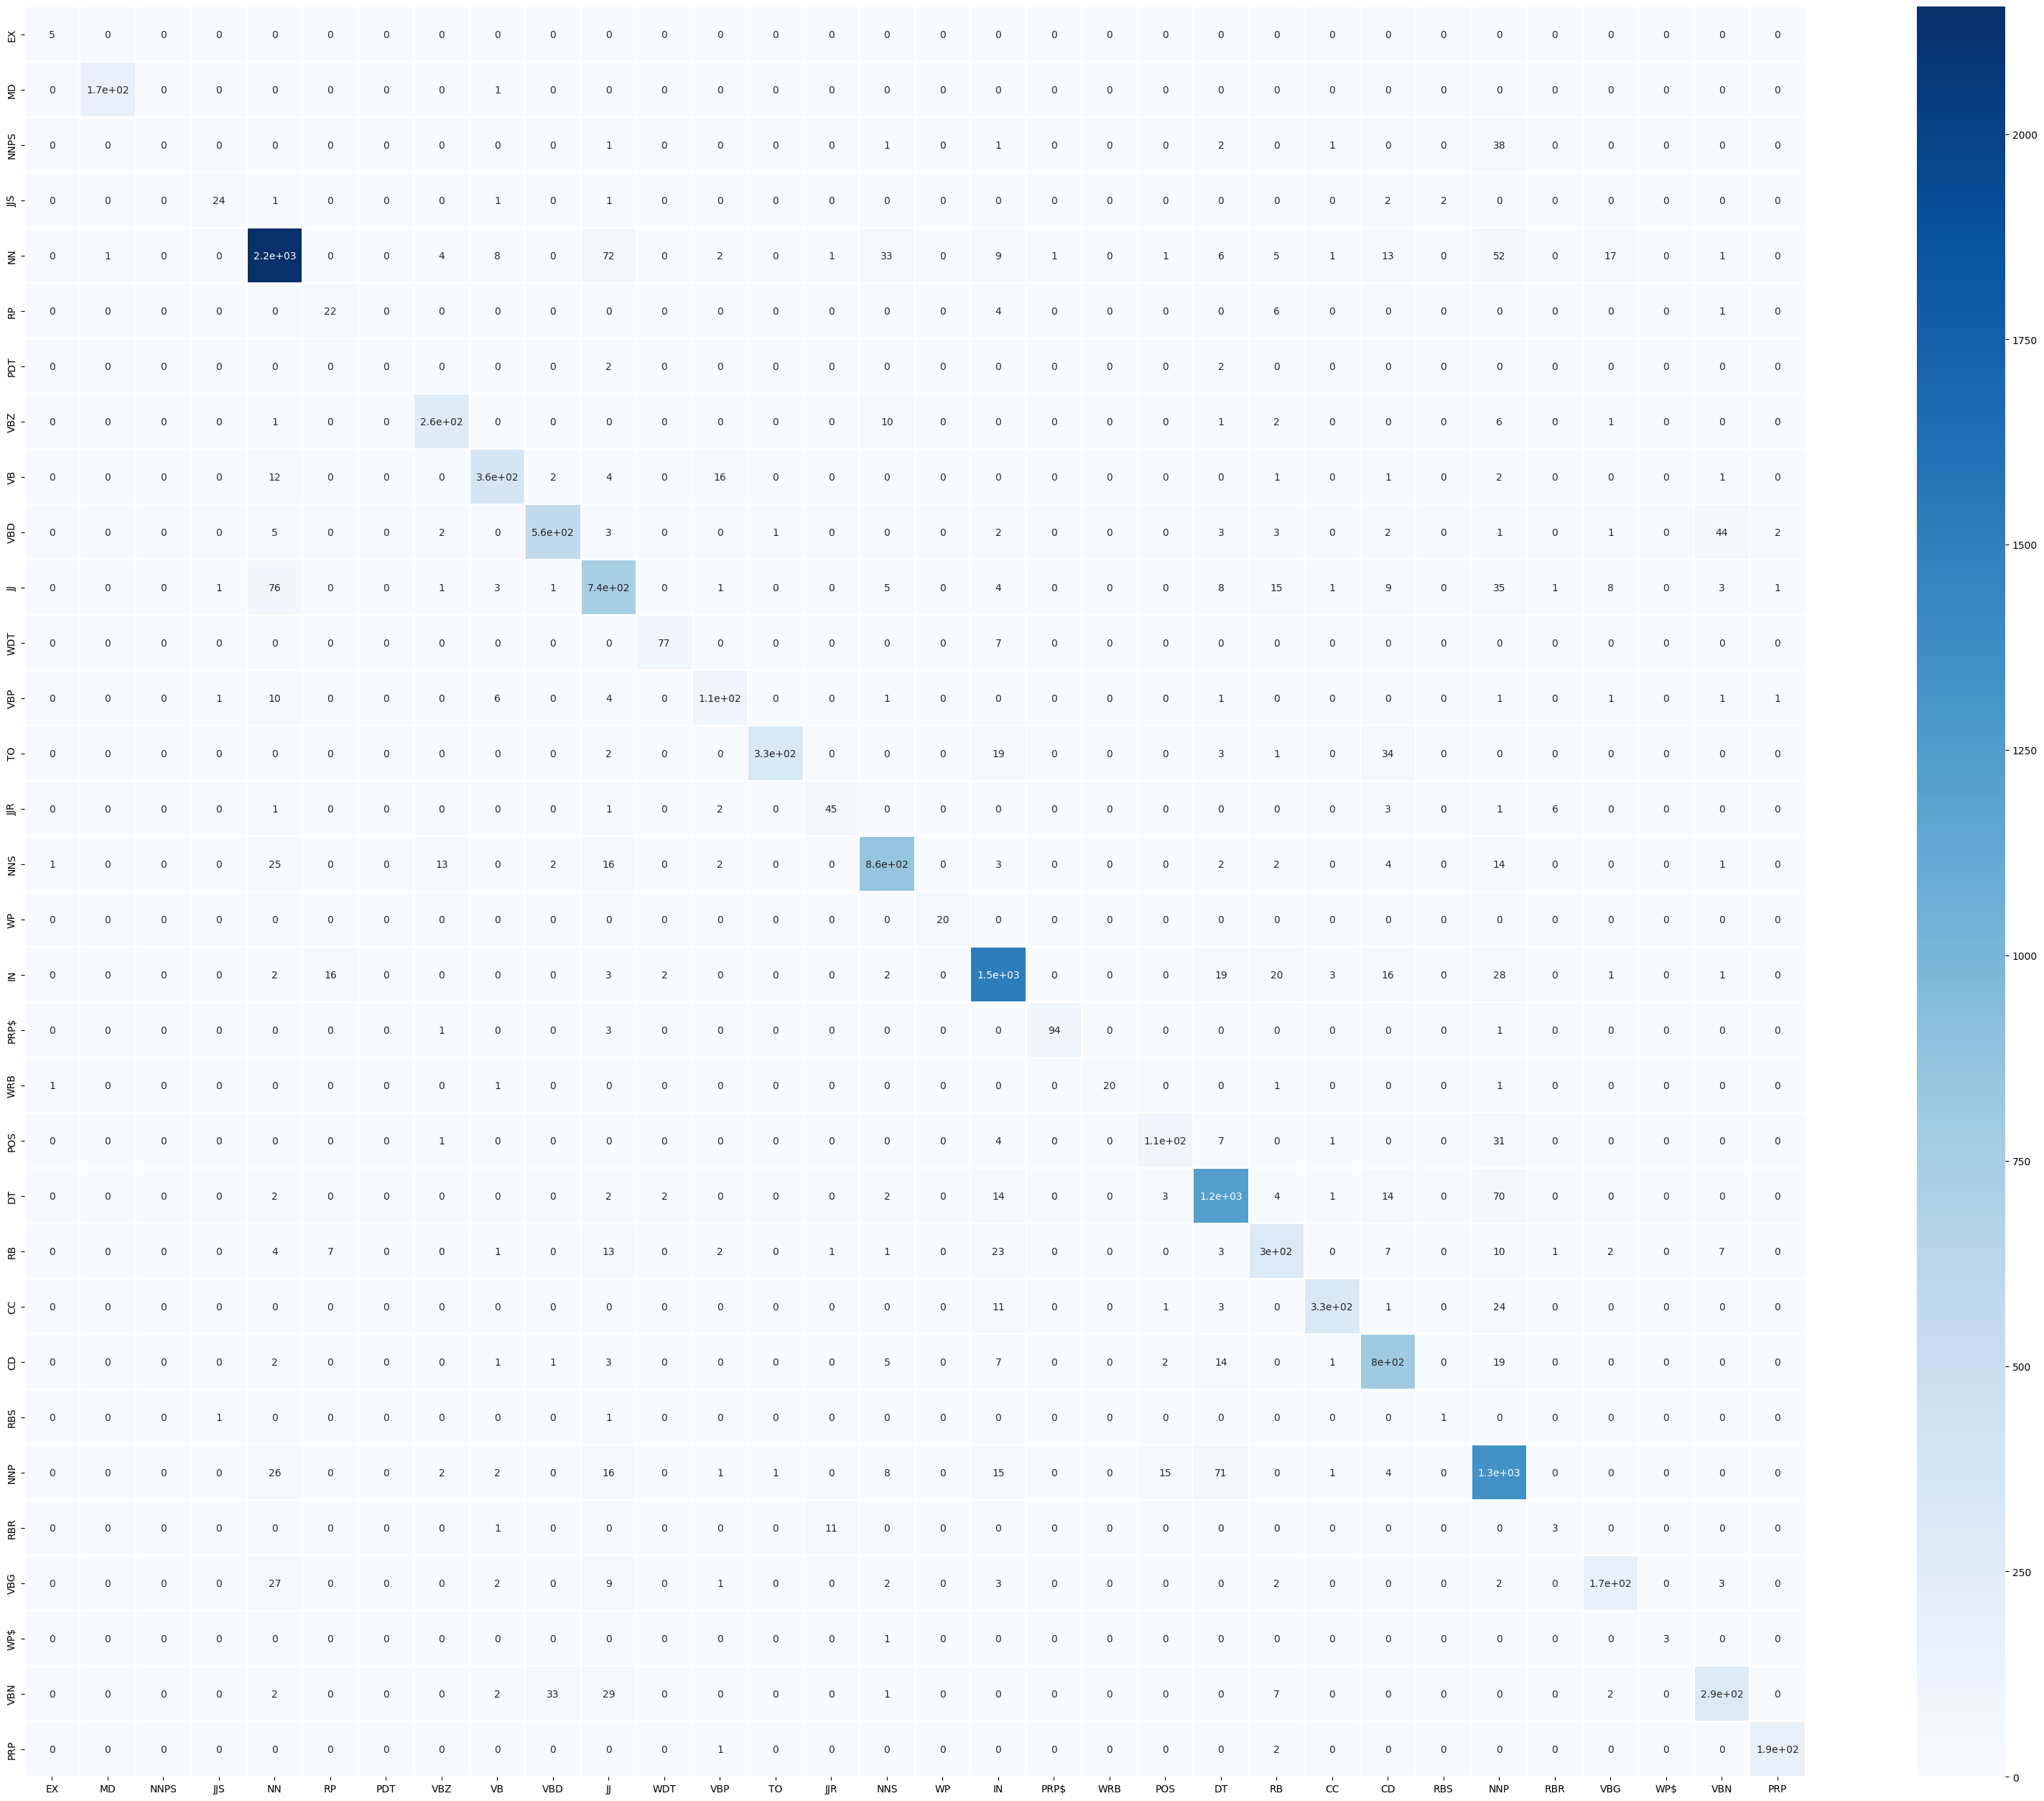

In [82]:
selected_pred = double_dense_pred_test
selected_targ = double_dense_targ_test

tags = [vocab.i2t(i) for i in set(selected_pred.tolist() + selected_targ.tolist())]

df_cm = build_confusion_matrix(selected_targ,selected_pred,tags)

build_errors_dictionary(df_cm)

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End